# **Explainable Artificial Intelligence**

In [2]:
import src.settings.base as stg
from src.infrastructure.dataframecreation import DataFrameBuilder
from src.domain.featureselection import FeatureSelector
from src.interface.plots import plot_feature_importance

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import eli5
from pdpbox import pdp, get_dataset, info_plots
from pycebox.ice import ice, ice_plot
import treeinterpreter
import shap

import warnings
warnings.filterwarnings("ignore")

In [8]:
df = FeatureSelector().women_decisions
X = FeatureSelector().women_decisions_features
Y = FeatureSelector().women_decisions_target

In [9]:
test_size = stg.TEST_SIZE
seed = stg.SEED
num_folds = stg.NUM_FOLDS
scoring = stg.SCORING
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [11]:
rfc = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=10)
rfc= rfc.fit(X_train,Y_train)

## 1. Scikit-learn feature_importances_ XAI

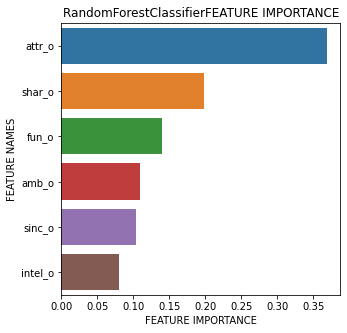

In [4]:
plot_feature_importance(rfc[1].feature_importances_,names=stg.COLS, model_type='RandomForestClassifier')

On remarque plusieurs choses :

- L'**attractivité** est la variable explicative qui pèse le plus dans l'intelligibilité du modèle.
- Les **passions communes** ont également un poids important, mais près de deux fois moindre.
- Suivent le **fun**, l'**ambition**, la **sincérité** et l'**intelligence**.
- Si certaines variables pèsent plus, aucune n'est sans importance.

## 2. eli5 XAI

In [5]:
rfc.fit(X_train,Y_train)
eli5.show_weights(rfc)

# Feature x0 = attr_o
# Feature x3 = fun_o
# Feature x5 = shar_o
# Feature x4 = amb_o
# Feature x1 = intel_o
# Feature x2 = sinc_o

Le diagnostic est similaire avec le même trio de tête mais dont le poids individuel est mieux réparti. 

Les femmes semblent se tourner vers des hommes **attirants** d'abord, et avec qui elles partagent des expériences **funs** et ont des choses **en commun**.

Les considérations plus morales et intellectuelles, si elle ne pèsent pas rien, pèsent moins.

## 3. Partial Dependence Plot XAI

In [30]:
f_predict = lambda x: rfc.predict(x)

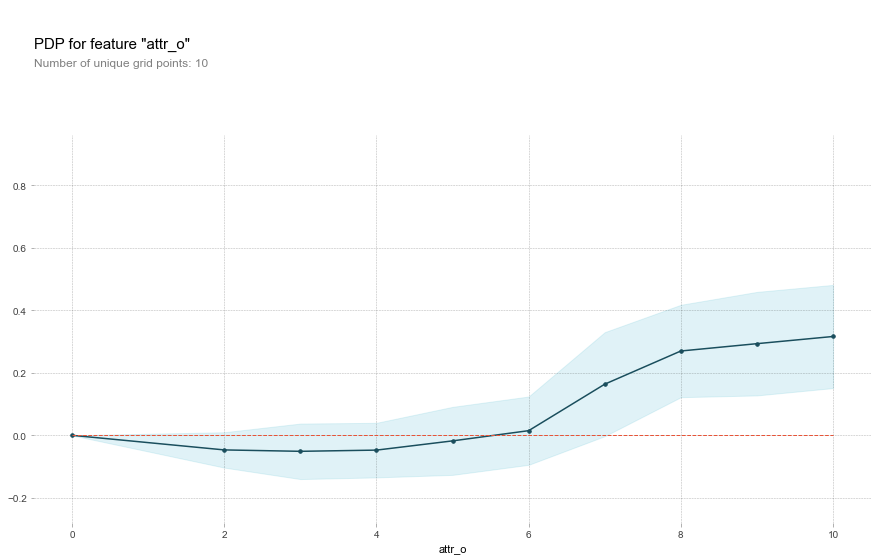

In [7]:
variable = stg.ATTRACTIVENESS_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité de l'attractivité dans la décision est nulle ou négative entre 0 et 6; elle devient largement positive et croissante de 6 à 10. 

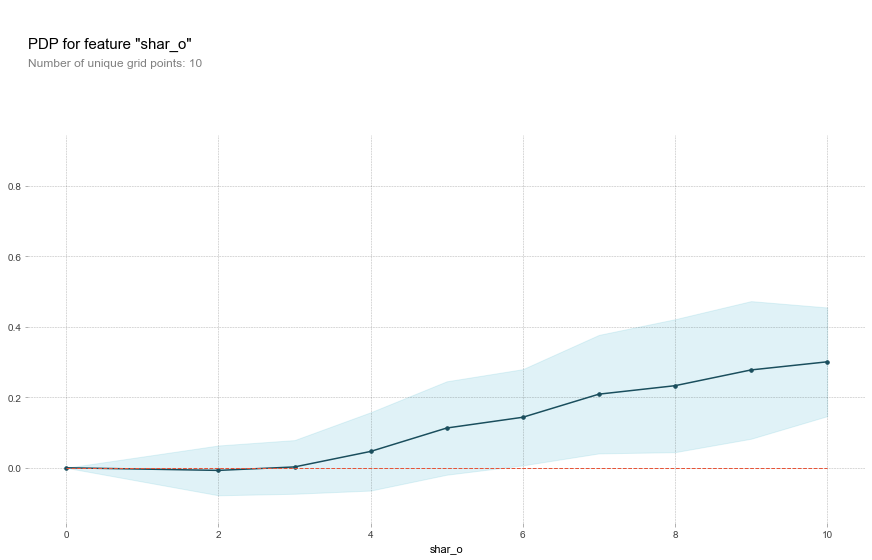

In [8]:
variable = stg.SHARED_INTERESTS_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité des passions communes dans la décision est nulle entre 0 et 3; elle devient largement positive et croissante de 3 à 10. 

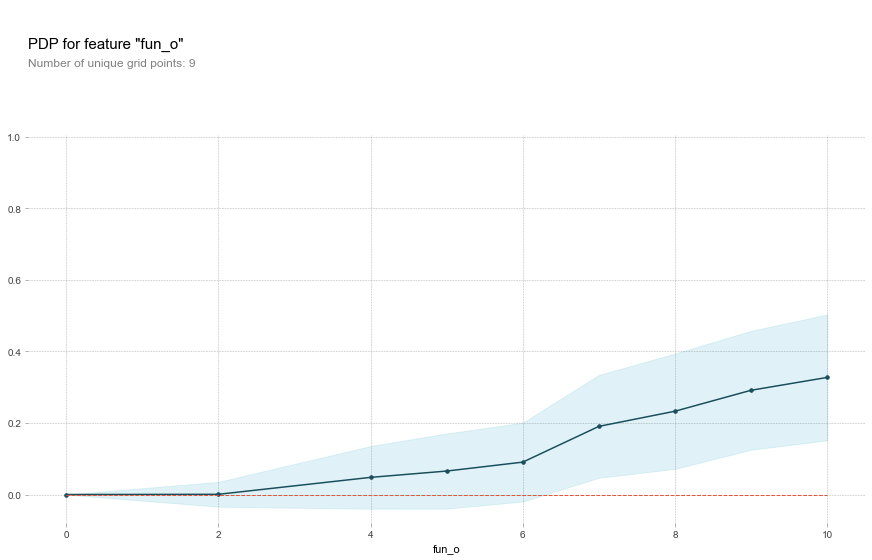

In [9]:
variable = stg.FUN_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité du fun dans la décision est nulle entre 0 et 2; elle devient largement positive et croissante de 2 à 10.

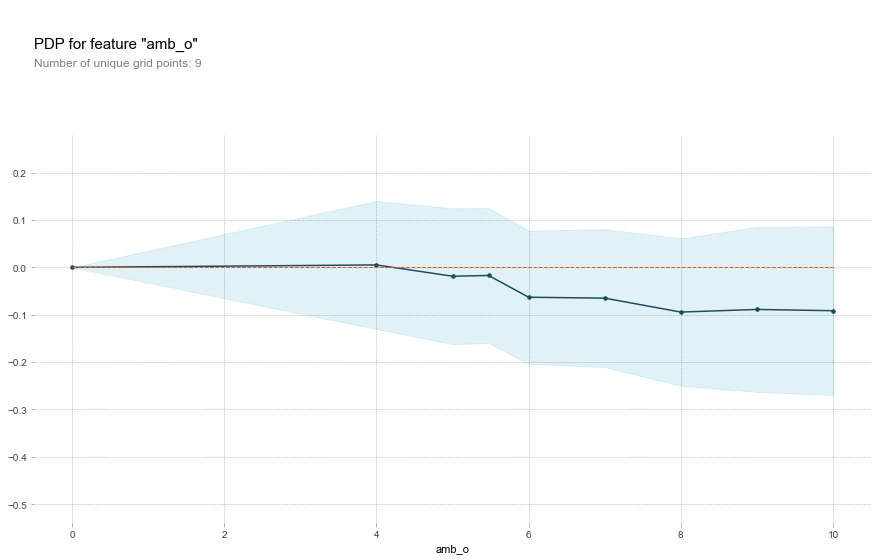

In [12]:
variable = stg.AMBITION_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité de l'ambition dans la décision est nulle entre 0 et 4; elle devient largement négative et décroissante puis stable de 4 à 10. 

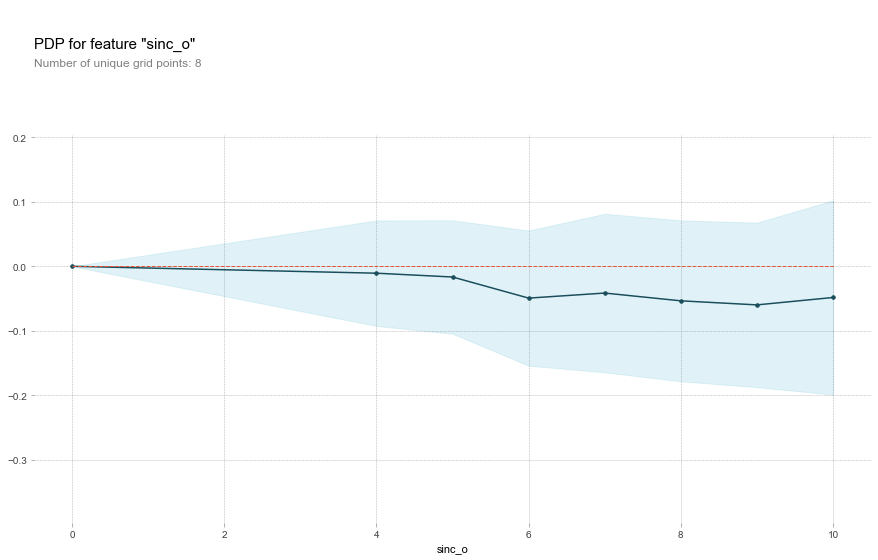

In [13]:
variable = stg.SINCERITY_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité de sincérité dans la décision est nulle entre 0 et 2; elle devient négative et décroissante de 2 à 10. 

In [14]:
variable = stg.INTELLIGENCE_O

pdp_goals = pdp.pdp_isolate(model=rfc,
                            dataset=X_test,
                            model_features=X_test.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', #possible values: 'equal' or 'percentile'
)

pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
plt.show()

L'explicabilité de l'intelligence dans la décision est nulle entre 0 et 5; elle devient négative et décroissante de 5 à 8, puis recroît entre 8 et 10. 

**Bilan** : On retrouve le même poids accordé aux 3 features d'attractivité, de fun et de passions communes.

## 4. Pycebox XAI

Text(0.5, 1.0, 'ICE Curves')

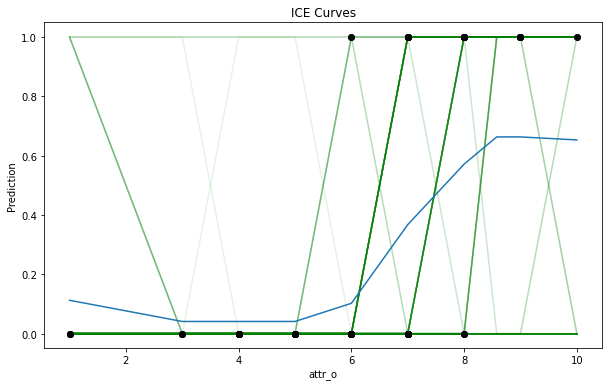

In [10]:
X_ref = X_test.copy().sample(100)
variable = stg.ATTRACTIVENESS_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

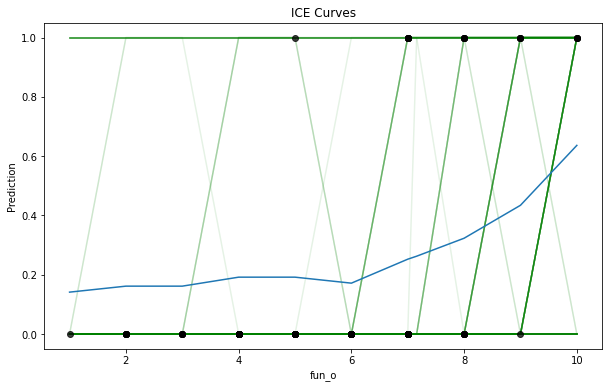

In [11]:
X_ref = X_test.copy().sample(100)
variable = stg.FUN_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

In [12]:
X_ref = X_test.copy().sample(100)
variable = stg.SHARED_INTERESTS_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

Pour les trois features, à mesure que la variable croît, l'explicabilité croît aussi.

In [31]:
X_ref = X_test.copy().sample(100)
variable = stg.INTELLIGENCE_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

In [32]:
X_ref = X_test.copy().sample(100)
variable = stg.SINCERITY_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

In [33]:
X_ref = X_test.copy().sample(100)
variable = stg.AMBITION_O

ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

Text(0.5, 1.0, 'ICE Curves')

Pour les trois autres features, à mesure que la variable croît, l'explicabilité reste stable ou décroît.

Pycebox exigeant beaucoup plus de données pour révéler son intérêt (peu de lignes vertes), ses résultats, si ils confortent ce que l'on voit avec les autres packages d'intelligibilité, restent de peu d'intérêt ici. 

## 5. Shap XAI

In [15]:
shap.initjs()
X_train_small = X_train.copy().sample(200)

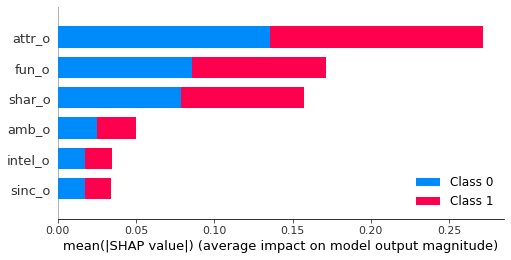

In [16]:
shap_values = shap.TreeExplainer(rfc).shap_values(X_train_small)
shap.summary_plot(shap_values, X_train_small, plot_type="bar")

Même trio de tête avec plus de poids encore par rapport aux trois autres features.

In [17]:
X_ref_shap = X_test.copy()

In [18]:
%%time
explanation = shap.TreeExplainer(rfc)
shap_values = explanation.shap_values(X_ref_shap)

CPU times: user 556 ms, sys: 1.96 ms, total: 558 ms
Wall time: 557 ms


In [20]:
shap.dependence_plot(stg.ATTRACTIVENESS_O, shap_values[0], X_ref_shap)

In [21]:
shap.dependence_plot(stg.FUN_O, shap_values[0], X_ref_shap)

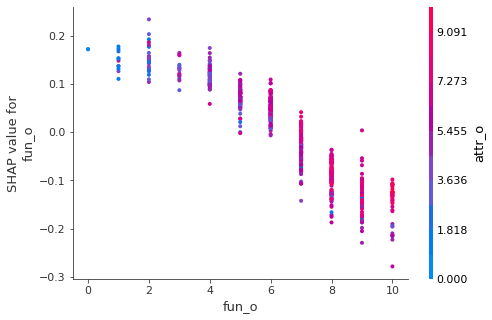

In [22]:
shap.dependence_plot(stg.FUN_O, shap_values[0], X_ref_shap)

On observe une même forme générale de la dépendence pour les trois premières variables explicatives.

In [24]:
shap.dependence_plot(stg.AMBITION_O, shap_values[0], X_ref_shap)

In [25]:
shap.dependence_plot(stg.INTELLIGENCE_O, shap_values[0], X_ref_shap)

In [27]:
shap.dependence_plot(stg.SINCERITY_O, shap_values[0], X_ref_shap)

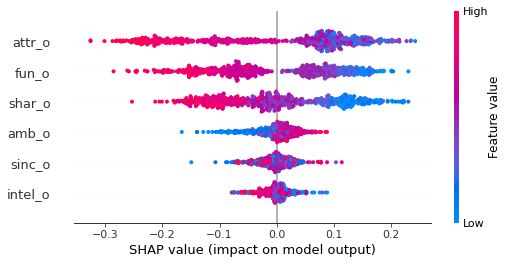

In [23]:
shap.summary_plot(shap_values[0], X_ref_shap, plot_type="dot")